In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/My Drive/plant_disease_detection/corn'

/content/drive/.shortcut-targets-by-id/1m0IGHkaDGDFqYJN-kaYjAf2eBNA-jgvF/plant_disease_detection/corn


In [ ]:
ls corndata/Corn

'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'/
'Corn_(maize)___Common_rust_'/
'Corn_(maize)___healthy'/
'Corn_(maize)___Northern_Leaf_Blight'/


In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=5, mode='min', verbose=1) 
checkpoint = ModelCheckpoint('model_best_weights_v2.h5', monitor='loss', verbose=1, save_best_only=True, mode='min', period=1)

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'corndata'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)
 
    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)
 
        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)
 
            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Image loading completed


In [ ]:
image_size = len(image_list)

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 85, 85, 64)       

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
20/20 [==============================] - 159s 8s/step - loss: 0.7981 - accuracy: 0.5967 - val_loss: 1.5823 - val_accuracy: 0.2812
Epoch 2/50
20/20 [==============================] - 136s 7s/step - loss: 0.2894 - accuracy: 0.8427 - val_loss: 1.9553 - val_accuracy: 0.2188
Epoch 3/50
20/20 [==============================] - 136s 7s/step - loss: 0.2868 - accuracy: 0.8196 - val_loss: 1.5504 - val_accuracy: 0.2313
Epoch 4/50
20/20 [==============================] - 137s 7s/step - loss: 0.2636 - accuracy: 0.8186 - val_loss: 0.7479 - val_accuracy: 0.3750
Epoch 5/50
20/20 [==============================] - 151s 8s/step - loss: 0.2375 - accuracy: 0.8381 - val_loss: 0.8187 - val_accuracy: 0.2812
Epoch 6/50
20/20 [==============================] - 136s 7s/step - loss: 0.2009 - accuracy: 0.8709 - val_loss: 0.6851 - val_accuracy: 0.4125
Epoch 7/50
20/20 [==============================] - 136s 7s/step - loss: 0.2081 - accuracy: 0.8676 - val_loss: 1.0680 - val_accuracy: 0.1562
Epoch 8/50
20

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
5/5 [==============================] - 7s 1s/step - loss: 0.0796 - accuracy: 0.9500
Test Accuracy: 94.9999988079071


In [ ]:
print(f"Test Accuracy: {scores[1]*100}")

Test Accuracy: 94.9999988079071


In [ ]:
model.save('CNN_corn.h5')

In [ ]:
from keras.models import load_model
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
cd '/content/drive/My Drive/plant_disease_detection/corn'

/content/drive/My Drive/plant_disease_detection/corn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
default_image_size = tuple((256,256))
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
label_binarizer = pickle.load(open('label_transform.pkl','rb'))

In [ ]:
from keras.models import load_model
model = load_model('CNN_corn.h5')

In [ ]:
ls 'corndata/Corn/Corn_(maize)___Northern_Leaf_Blight/ea9ba5b2-e8e7-48c8-ac16-d594a9e5cc51___RS_NLB  4443 copy 2.jpg'

'005318c8-a5fa-4420-843b-23bdda7322c2___RS_NLB 3853 copy.jpg'
'0079c731-80f5-4fea-b6a2-4ff23a7ce139___RS_NLB 4121.JPG'
'008d9af0-7568-4a67-bb1a-0e915836ddc0___RS_NLB 4165 copy 2.jpg'
'00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG'
'00a55069-3fa3-405b-8d87-4d3408a6ed98___RS_NLB 3645.JPG'
'0118e276-ee7b-4fed-961d-057590ae9f7f___RS_NLB 4666 copy 2.jpg'
'011b766d-7744-420d-a1a1-57bdff9b4ddd___RS_NLB 4128.JPG'
'019e3ef7-aae4-4fd3-b95f-b4e914df7a39___RS_NLB 4284.JPG'
'022817bd-6a93-4b0a-ac39-1cc4094128b1___RS_NLB 3476.JPG'
'024fb674-fdcb-4777-a8d6-8a13abb58d8f___RS_NLB 3992.JPG'
'02504be2-4192-42f3-957d-df2841103562___RS_NLB 3955 copy.jpg'
'028159fc-995e-455a-8d60-6d377580a898___RS_NLB 4023.JPG'
'028a7e62-b520-42fe-8607-ee4d4bc6764d___RS_NLB 3844.JPG'
'02eee796-1a1e-4d63-8247-a6aac6bfb272___RS_NLB 3546.JPG'
'033219ed-54a8-4f95-ab72-c87b90189006___RS_NLB 3818 copy 2.jpg'
'035ce877-baf8-4ce2-b7c4-d262c577d628___RS_NLB 3934.JPG'
'03c49c3c-6b9a-4253-b496-c9d5bcd819a9___RS_NLB 4249.JPG'


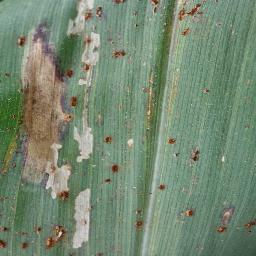

In [ ]:
from IPython.display import Image
filepath = 'corndata/Corn/Corn_(maize)___Northern_Leaf_Blight/f3a574c8-043a-4804-bdba-addb50450720___RS_NLB 3553 copy.jpg'
Image(filepath)

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image = convert_image_to_array(filepath)
test_image = np.array(test_image, dtype=np.float16) / 225.0
result = model.predict(test_image.reshape(1,256,256,3))
result = np.argmax(result,axis=1)
pred = label_binarizer.classes_[result[0]]

print("Predicted - "+pred)

Predicted - Corn_(maize)___Northern_Leaf_Blight
